# Local Projections

This notebook implements the Local Projections method proposed by Jordà (2005) with the monetary policy shock series provided by Ramey (2016)*. At the end of the notebook, we will replicate Figure 2 from Ramey (2016). 

*Ramey, Valerie A. "Macroeconomic shocks and their propagation." Handbook of macroeconomics 2 (2016): 71-162.

In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import statsmodels.api as sm
from scipy.stats import t

## LP regression

We want to run the following regression 
$$
y_{t + h} = \alpha_h + \beta_h * shock_t + \boldsymbol{\gamma}_t \boldsymbol{x}_t + ε_{t + h}
$$

where $y_t$ is the variable of interest (e.g.  log of industrial production) and $shock_t$ is the Romer and Romer (R&R) monetary policy shock series. Ramey (2016) states that she includes the following control variables:
- 2 lags of the R&R shock, the federal funds rate, the log of industrial production, the unemployment rate, the log of the CPI, and the log of the commodity price index.
- contemporaneous values for the unemployment rate, industrial production and the two price indices  
    (This specification resembles the "recusiveness assumption". It means that monetary policy shocks do not affect the other variables in the economy contemporaneously. This leads to the IRFs at h=0 being equal to zero, except for the federal funds rate, that is allowed to move contemporaneously).

## Data Transformation
We first read in the relevant data and apply the transformation that Ramey applies in her Handbook chapter. The dictionary below specifies the names of the variables used.

In [4]:
# Read data from Excel file containing Ramey (2016) monetary policy data.
data = pd.read_excel('data/Ramey_data.xlsx', sheet_name='Monthlydat6996')

# Define relevant series to keep
relevant_series_dict = {
    'LIP': 'log of industrial production',
    'LCPI': 'log of CPI',
    'UNEMP': 'unemployment rate',
    'LPCOM': 'log of commodity price index',
    'FFR': 'federal funds rate',
    'RRSHOCK': 'Romer and Romer shock'
}
print(f"Keep the following series: {list(relevant_series_dict.keys())}")
data_selected = data[relevant_series_dict.keys()]
data_selected.head()

Keep the following series: ['LIP', 'LCPI', 'UNEMP', 'LPCOM', 'FFR', 'RRSHOCK']


,LIP,LCPI,UNEMP,LPCOM,FFR,RRSHOCK
0,3.676827,3.575151,3.4,4.633563,6.30,0.000000
1,3.683206,3.577948,3.4,4.655388,6.61,0.000000
2,3.691017,3.586293,3.4,4.665607,6.79,-0.245942
3,3.687328,3.591818,3.4,4.680092,7.41,0.404899
4,3.683543,3.594569,3.4,4.698661,8.67,0.203151


In [5]:
# Data transformations
data_transformed = data_selected.copy()
data_transformed['LIP'] = data_transformed['LIP'] * 100      # x 100 as done in Ramey
data_transformed['LCPI'] = data_transformed['LCPI'] * 100    # x 100 as done in Ramey
# create lags of variables
data_transformed[['lag_LIP', 'lag_UNEMP', 'lag_LCPI', 'lag_LPCOM', 'lag_FFR', 'lag_RRSHOCK']] = data_transformed[['LIP', 'UNEMP', 'LCPI', 'LPCOM', 'FFR', 'RRSHOCK']].shift(1)
data_transformed[['lag2_LIP', 'lag2_UNEMP', 'lag2_LCPI', 'lag2_LPCOM', 'lag2_FFR', 'lag2_RRSHOCK']] = data_transformed[['LIP', 'UNEMP', 'LCPI', 'LPCOM', 'FFR', 'RRSHOCK']].shift(2)
data_transformed = data_transformed.iloc[2:,:] # Take out the first two rows. Alternatively, data = data.dropna()

display(data_transformed)

,LIP,LCPI,UNEMP,LPCOM,FFR,RRSHOCK,lag_LIP,lag_UNEMP,lag_LCPI,lag_LPCOM,lag_FFR,lag_RRSHOCK,lag2_LIP,lag2_UNEMP,lag2_LCPI,lag2_LPCOM,lag2_FFR,lag2_RRSHOCK
2,369.101717,358.629287,3.4,4.665607,6.79,-0.245942,368.320589,3.4,357.794789,4.655388,6.61,0.000000,367.682712,3.4,357.515069,4.633563,6.30,0.000000
3,368.732825,359.181774,3.4,4.680092,7.41,0.404899,369.101717,3.4,358.629287,4.665607,6.79,-0.245942,368.320589,3.4,357.794789,4.655388,6.61,0.000000
4,368.354274,359.456877,3.4,4.698661,8.67,0.203151,368.732825,3.4,359.181774,4.680092,7.41,0.404899,369.101717,3.4,358.629287,4.665607,6.79,-0.245942
5,369.326482,360.004824,3.5,4.712409,8.90,-0.020495,368.354274,3.4,359.456877,4.698661,8.67,0.203151,368.732825,3.4,359.181774,4.680092,7.41,0.404899
6,369.853024,360.549785,3.5,4.712409,8.61,0.180169,369.326482,3.5,360.004824,4.712409,8.90,-0.020495,368.354274,3.4,359.456877,4.698661,8.67,0.203151
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
331,436.077491,505.751888,5.1,5.750348,5.22,-0.064381,435.493418,5.5,505.624581,5.735120,5.40,-0.040548,435.672165,5.3,505.433315,5.734958,5.27,0.000000
332,436.763355,506.069449,5.2,5.734861,5.30,-0.042311,436.077491,5.1,505.751888,5.750348,5.22,-0.064381,435.493418,5.5,505.624581,5.735120,5.40,-0.040548
333,436.686985,506.386006,5.2,5.696624,5.24,0.000000,436.763355,5.2,506.069449,5.734861,5.30,-0.042311,436.077491,5.1,505.751888,5.750348,5.22,-0.064381
334,437.555700,506.701563,5.4,5.651928,5.31,0.047883,436.686985,5.2,506.386006,5.696624,5.24,0.000000,436.763355,5.2,506.069449,5.734861,5.30,-0.042311


In [6]:
# Below I will also use list comprehension to create new lists of variables
data_transformed = data_selected.copy()
data_transformed['LIP'] = data_transformed['LIP'] * 100      # x 100 as done in Ramey
data_transformed['LCPI'] = data_transformed['LCPI'] * 100    # x 100 as done in Ramey

# create a list of the names of the variables
vars_to_lag = list(relevant_series_dict.keys())
n_lags = 2 # Number of lags to create
# Create the lagged variable
for var in vars_to_lag:
    for i in range(1, n_lags+1): # Loop from 1 to n_lags
        var_name = f'{var}_lag{i}'
        print(f'Create {var_name}')
        # Create the lagged variable
        data_transformed[var_name] = data_transformed[var].shift(i)

data_transformed.head()

Create LIP_lag1
Create LIP_lag2
Create LCPI_lag1
Create LCPI_lag2
Create UNEMP_lag1
Create UNEMP_lag2
Create LPCOM_lag1
Create LPCOM_lag2
Create FFR_lag1
Create FFR_lag2
Create RRSHOCK_lag1
Create RRSHOCK_lag2


,LIP,LCPI,UNEMP,LPCOM,FFR,RRSHOCK,LIP_lag1,LIP_lag2,LCPI_lag1,LCPI_lag2,UNEMP_lag1,UNEMP_lag2,LPCOM_lag1,LPCOM_lag2,FFR_lag1,FFR_lag2,RRSHOCK_lag1,RRSHOCK_lag2
0,367.682712,357.515069,3.4,4.633563,6.30,0.000000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,368.320589,357.794789,3.4,4.655388,6.61,0.000000,367.682712,NaN,357.515069,NaN,3.4,NaN,4.633563,NaN,6.30,NaN,0.000000,NaN
2,369.101717,358.629287,3.4,4.665607,6.79,-0.245942,368.320589,367.682712,357.794789,357.515069,3.4,3.4,4.655388,4.633563,6.61,6.30,0.000000,0.000000
3,368.732825,359.181774,3.4,4.680092,7.41,0.404899,369.101717,368.320589,358.629287,357.794789,3.4,3.4,4.665607,4.655388,6.79,6.61,-0.245942,0.000000
4,368.354274,359.456877,3.4,4.698661,8.67,0.203151,368.732825,369.101717,359.181774,358.629287,3.4,3.4,4.680092,4.665607,7.41,6.79,0.404899,-0.245942


## LP regression

Run 
$$
y_{t + h} = \alpha_h + \beta_h * shock_t + \boldsymbol{\gamma}_t \boldsymbol{x}_t + ε_{t + h}
$$

with $\boldsymbol{x}_t$ being the vector of control variables states above.


### h = 0

In [7]:
indep_var = "LIP"
dep_vars = "RRSHOCK + LIP + LCPI + LPCOM + UNEMP + \
            RRSHOCK_lag1 + LIP_lag1 + LCPI_lag1 + LPCOM_lag1 + UNEMP_lag1 + FFR_lag1 + \
            RRSHOCK_lag2 + LIP_lag2 + LCPI_lag2 + LPCOM_lag2 + UNEMP_lag2 + FFR_lag2"
LP_formula = f"{indep_var} ~ {dep_vars}"
print(f"Formula: {LP_formula}")

Formula: LIP ~ RRSHOCK + LIP + LCPI + LPCOM + UNEMP +             RRSHOCK_lag1 + LIP_lag1 + LCPI_lag1 + LPCOM_lag1 + UNEMP_lag1 + FFR_lag1 +             RRSHOCK_lag2 + LIP_lag2 + LCPI_lag2 + LPCOM_lag2 + UNEMP_lag2 + FFR_lag2


In [22]:
# Run the regression for LIP and the horizon h = 0 (recursive identification)
indep_var = "LIP"
dep_vars = "RRSHOCK + LIP + LCPI + LPCOM + UNEMP + \
            RRSHOCK_lag1 + LIP_lag1 + LCPI_lag1 + LPCOM_lag1 + UNEMP_lag1 + FFR_lag1 + \
            RRSHOCK_lag2 + LIP_lag2 + LCPI_lag2 + LPCOM_lag2 + UNEMP_lag2 + FFR_lag2"
LP_formula = f"{indep_var} ~ {dep_vars}"
model = sm.formula.ols(formula=LP_formula, data=data_transformed)
# Estimate and use 'HAC' standard errors
results = model.fit(cov_type='HAC', cov_kwds={'maxlags':24})
# How to determine the number of lags in HAC:
# Annual data = 1 - 2 lags. Quarterly data = 4 - 8 lags. Monthly data = 12 - 24 lags.

print(results.summary())
# Note something about the results in terms of fit?


                            OLS Regression Results                            
Dep. Variable:                    LIP   R-squared:                       1.000
Model:                            OLS   Adj. R-squared:                  1.000
Method:                 Least Squares   F-statistic:                 1.299e+24
Date:                Thu, 15 May 2025   Prob (F-statistic):               0.00
Time:                        17:21:02   Log-Likelihood:                 7816.7
No. Observations:                 334   AIC:                        -1.560e+04
Df Residuals:                     316   BIC:                        -1.553e+04
Df Model:                          17                                         
Covariance Type:                  HAC                                         
                   coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------------
Intercept     1.705e-12   2.87e-10      0.006   

In [24]:
print("Extract the parameters and standard errors")
coefficients = results.params
stderrors = results.bse

# print(coefficients)

# Remember, that we are interested in the paramter of the Romer and Romer shock
print(f"Coefficient for beta_0: {coefficients['RRSHOCK']}")

pd.concat((coefficients, stderrors), axis=1, keys=['coefficients', 'standard errors'])

Extract the parameters and standard errors
Coefficient for beta_0: 8.526512829121202e-14


,coefficients,standard errors
Intercept,1.705303e-12,2.868825e-10
RRSHOCK,8.526513e-14,2.524284e-12
LIP,1.000000e+00,1.373562e-12
LCPI,-1.989520e-13,6.700067e-12
LPCOM,0.000000e+00,4.173275e-11
UNEMP,-1.367795e-13,7.353411e-12
RRSHOCK_lag1,-2.842171e-14,2.944330e-12
LIP_lag1,7.105427e-15,7.222827e-13
LCPI_lag1,3.410605e-13,2.189832e-12
LPCOM_lag1,4.405365e-13,2.607589e-11


### h = 1

When $h=1$, the regression is
$$
y_{t + 1} = \alpha_1 + \beta_1 * shock_t + \boldsymbol{\gamma}_t \boldsymbol{x}_t + ε_{t + 1}
$$

In [25]:
# h = 1 --> variable of interest LIP leads the other variables by 1
data_h = data_transformed.copy()
data_h['LIP_lead1'] = data_h['LIP'].shift(-1) # Shift LIP by -1 to lead the other variables
data_h[['LIP', 'LIP_lead1']].head(3)

,LIP,LIP_lead1
0,367.682712,368.320589
1,368.320589,369.101717
2,369.101717,368.732825


In [26]:
# Run the regression for LIP and the horizon h = 1 (recursive identification)
indep_var = "LIP_lead1"
LP_formula = f"{indep_var} ~ {dep_vars}"
model = sm.formula.ols(formula=LP_formula, data=data_h)
# Estimate and use 'HAC' standard errors
results = model.fit(cov_type='HAC', cov_kwds={'maxlags':24})
print(results.summary())


                            OLS Regression Results                            
Dep. Variable:              LIP_lead1   R-squared:                       0.999
Model:                            OLS   Adj. R-squared:                  0.999
Method:                 Least Squares   F-statistic:                 4.190e+04
Date:                Thu, 15 May 2025   Prob (F-statistic):               0.00
Time:                        17:23:27   Log-Likelihood:                -324.13
No. Observations:                 333   AIC:                             684.3
Df Residuals:                     315   BIC:                             752.8
Df Model:                          17                                         
Covariance Type:                  HAC                                         
                   coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------------
Intercept        2.5603      2.427      1.055   

In [27]:
print("Extract the parameters and standard errors")
coefficients = results.params
stderrors = results.bse

# Remember, that we are interested in the paramter of the Romer and Romer shock
print(f"Coefficient for beta_0: {coefficients['RRSHOCK']}")

pd.concat((coefficients, stderrors), axis=1, keys=['coefficients', 'standard errors'])

Extract the parameters and standard errors
Coefficient for beta_0: 0.13330232118284613


,coefficients,standard errors
Intercept,2.560277,2.426611
RRSHOCK,0.133302,0.090791
LIP,1.153918,0.092312
LCPI,0.015124,0.129002
LPCOM,3.236362,2.762304
UNEMP,-0.612979,0.303164
RRSHOCK_lag1,-0.091640,0.072330
LIP_lag1,-0.191637,0.158199
LCPI_lag1,-0.272657,0.224615
LPCOM_lag1,-1.986677,3.868416


## LP regression for each horizon

In [13]:
horizon = 48 # LPs for 4 years after the shock
# Create an empty array to store the coefficients / impulse responses
thetas_RRSHOCK = np.zeros(horizon)
se_RRSHOCK= np.zeros(horizon)

In [28]:
# apply LP regression for each horizon
for h in range(0, horizon):
    data_h = data_transformed.copy()
    # shift the dependent variable by h periods 
    data_h['LIP_lead'] = data_h['LIP'].shift(-h)
    
    # Model for Industrial Production
    model_LIP = sm.formula.ols(formula=f"LIP_lead ~ {dep_vars}", data=data_h)
    results_LIP = model_LIP.fit(cov_type='HAC', cov_kwds={'maxlags':24})
    # store estimates
    thetas_RRSHOCK[h] = results_LIP.params['RRSHOCK']
    se_RRSHOCK[h] = results_LIP.bse['RRSHOCK']

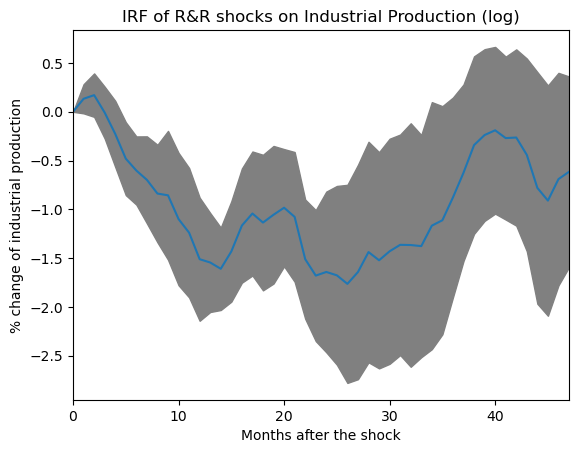

In [15]:
# Plot the IRF for LIP
plt.figure()
plt.plot(range(0,horizon), thetas_RRSHOCK)  # Plot the data points
plt.fill_between(range(0,horizon), thetas_RRSHOCK - 1.645 *  se_RRSHOCK, thetas_RRSHOCK + 1.645 *  se_RRSHOCK, color='grey')
plt.ylabel('% change of industrial production') # IP in logs
plt.xlabel('Months after the shock')
plt.xlim(0,horizon-1)
plt.title('IRF of R&R shocks on Industrial Production (log)')
plt.show()

# Replication of Figure 2 from Ramey (2016)
To replicate the figure, we need carry out the local projection for the other variables as well.

In [30]:
# specify max horizon of LP
horizon = 48
# initialize thetas and standard_errors
thetas = {
    'FFR': np.empty(horizon),
    'LIP': np.empty(horizon),
    'UNEMP': np.empty(horizon),
    'LCPI': np.empty(horizon)
}
standard_errors = {
    'FFR': np.empty(horizon),
    'LIP': np.empty(horizon),
    'UNEMP': np.empty(horizon),
    'LCPI': np.empty(horizon)
}

# specify the regression formulas
formulas = {
    'FFR': "FFR_lead ~ " + dep_vars,
    'LIP': "LIP_lead ~ " + dep_vars,
    'UNEMP': "UNEMP_lead ~ " + dep_vars,
    'LCPI': "LCPI_lead ~ " + dep_vars
}

In [31]:
# run LP for all horizons and different dependent variables
for h in range(0,horizon):
    data_h = data_transformed.copy()
    # shift the dependent variable by h periods and drop resulting na observations 
    data_h['LIP_lead'] = data_h['LIP'].shift(-h)
    data_h['UNEMP_lead'] = data_h['UNEMP'].shift(-h)
    data_h['LCPI_lead'] = data_h['LCPI'].shift(-h)
    data_h['FFR_lead'] = data_h['FFR'].shift(-h)
    data_h = data_h.dropna()     # when other variables are in period t, LIP is in period t+h 
    
    # Model for Federal Funds Rate
    model_FFR = sm.formula.ols(formula=formulas['FFR'], data=data_h)
    results_FFR = model_FFR.fit(cov_type='HAC', cov_kwds={'maxlags':24})
    
    thetas['FFR'][h] = results_FFR.params['RRSHOCK']
    standard_errors['FFR'][h] = results_FFR.bse['RRSHOCK']

    # Model for Industrial Production
    model_LIP = sm.formula.ols(formula=formulas['LIP'], data=data_h)
    results_LIP = model_LIP.fit(cov_type='HAC', cov_kwds={'maxlags':24})

    thetas['LIP'][h] = results_LIP.params['RRSHOCK']
    standard_errors['LIP'][h] = results_LIP.bse['RRSHOCK']
    
    # Model for Unemployment
    model_UNEMP = sm.formula.ols(formula=formulas['UNEMP'], data=data_h)
    results_UNEMP = model_UNEMP.fit(cov_type='HAC', cov_kwds={'maxlags':24})
    
    thetas['UNEMP'][h] = results_UNEMP.params['RRSHOCK']
    standard_errors['UNEMP'][h] = results_UNEMP.bse['RRSHOCK']
    
    # Model for Inflation
    model_LCPI = sm.formula.ols(formula=formulas['LCPI'], data=data_h)
    results_LCPI = model_LCPI.fit(cov_type='HAC', cov_kwds={'maxlags':24})
    
    thetas['LCPI'][h] = results_LCPI.params['RRSHOCK']
    standard_errors['LCPI'][h] = results_LCPI.bse['RRSHOCK']
    


In [32]:
# run LP for all horizons and different dependent variables with less lines of code
vars = ['FFR', 'LIP', 'UNEMP', 'LCPI']
for var in vars:
    print(f"Run LP for {var}")
    var_leading = f"{var}_lead"
    for h in range(0,horizon):
        data_h = data_transformed.copy()
        # shift the dependent variable by h periods and drop resulting na observations 
        data_h[var_leading] = data_h[var].shift(-h)
        data_h = data_h.dropna()   

        model_var = sm.formula.ols(formula=formulas[var], data=data_h)
        results_var = model_var.fit(cov_type='HAC', cov_kwds={'maxlags':24})

        # store estimates
        thetas[var][h] = results_var.params['RRSHOCK']
        standard_errors[var][h] = results_var.bse['RRSHOCK']

Run LP for FFR
Run LP for LIP
Run LP for UNEMP
Run LP for LCPI


## Plot IRFs

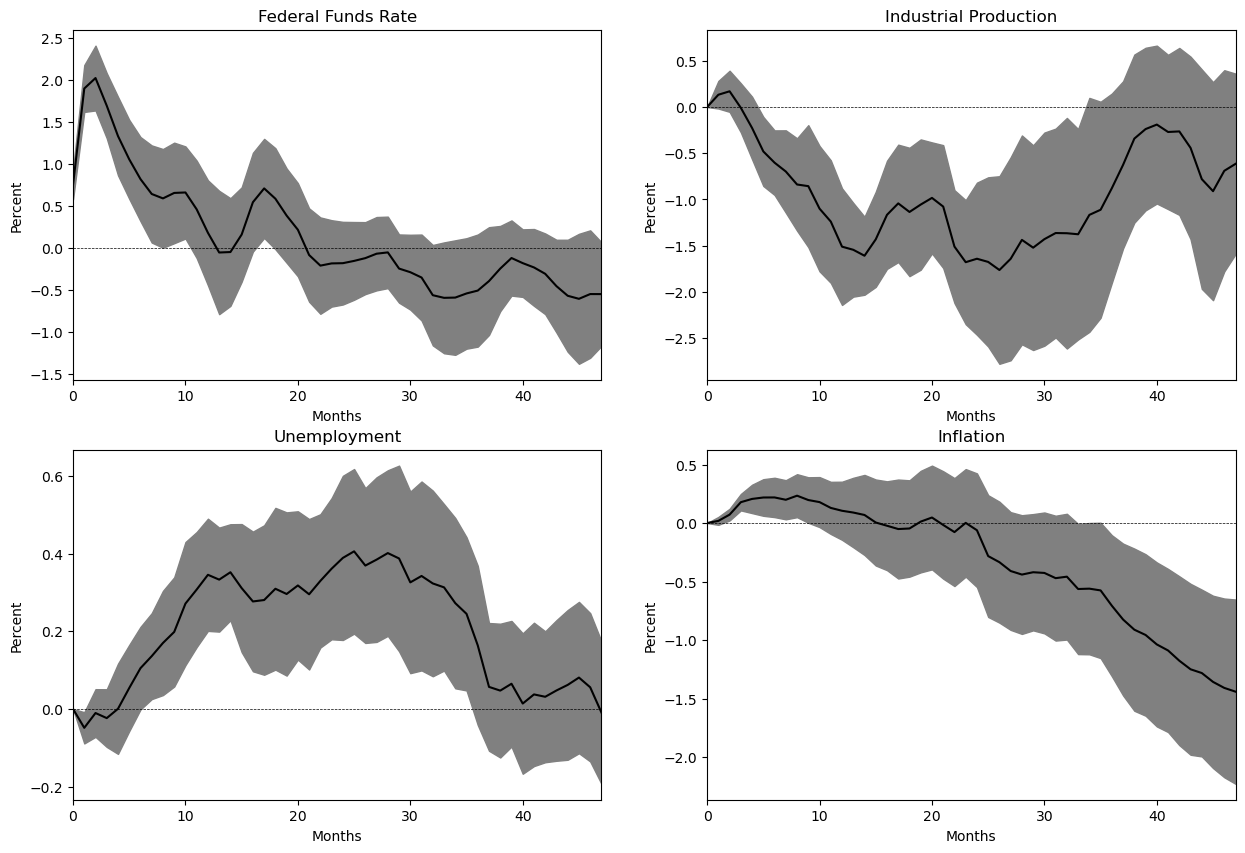

In [33]:
fig, axs = plt.subplots(2, 2, figsize=(15, 10))

axs[0,0].plot(np.arange(len(thetas['FFR'])), thetas['FFR'], color='black')
axs[0,0].fill_between(np.arange(horizon), thetas['FFR'] - 1.645 *  standard_errors['FFR'], thetas['FFR'] + 1.645 *  standard_errors['FFR'], color='grey')
axs[0,0].set_title('Federal Funds Rate')

axs[0,1].plot(np.arange(len(thetas['LIP'])), thetas['LIP'], color='black')
axs[0,1].fill_between(np.arange(horizon), thetas['LIP'] - 1.645 *  standard_errors['LIP'], thetas['LIP'] + 1.645 *  standard_errors['LIP'], color='grey')
axs[0,1].set_title('Industrial Production')

axs[1,0].plot(np.arange(len(thetas['UNEMP'])), thetas['UNEMP'], color='black')
axs[1,0].fill_between(np.arange(horizon), thetas['UNEMP'] - 1.645 *  standard_errors['UNEMP'], thetas['UNEMP'] + 1.645 *  standard_errors['UNEMP'], color='grey')
axs[1,0].set_title('Unemployment')

axs[1,1].plot(np.arange(len(thetas['LCPI'])), thetas['LCPI'], color='black')
axs[1,1].fill_between(np.arange(horizon), thetas['LCPI'] - 1.645 *  standard_errors['LCPI'], thetas['LCPI'] + 1.645 *  standard_errors['LCPI'], color='grey')
axs[1,1].set_title('Inflation')

# assign labels and limits for all axes
for ax in axs.flat:
    ax.set_xlabel('Months')
    ax.set_ylabel('Percent')
    ax.set_xlim(0, horizon-1)
    ax.axhline(0, color='black', linewidth=0.5, linestyle='--')

plt.show()

You can compare the figure to page 104 in: Ramey, Valerie A. "Macroeconomic shocks and their propagation." Handbook of macroeconomics 2 (2016): 71-162.